In [14]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Load hyperspectral image
data = sio.loadmat("Dataset/Indian_pines_corrected.mat")
gt = sio.loadmat("Dataset/Indian_pines_gt.mat")

# Extract arrays
X = data['indian_pines_corrected']
y = gt['indian_pines_gt']

print("HSI cube shape:", X.shape)
print("Ground truth shape:", y.shape)

HSI cube shape: (145, 145, 200)
Ground truth shape: (145, 145)


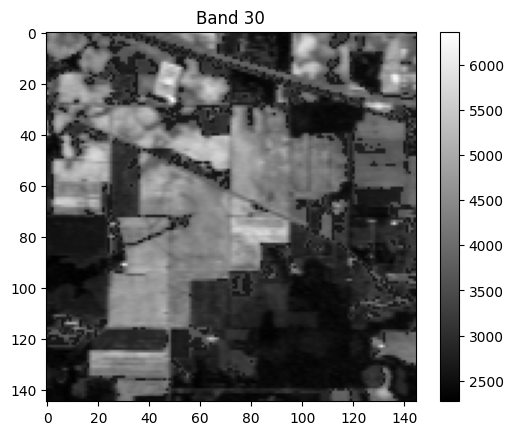

In [16]:
band_id = 30  # 10, 50, 100

plt.imshow(X[:, :, band_id], cmap='gray')
plt.title(f"Band {band_id}")
plt.colorbar()
plt.show()

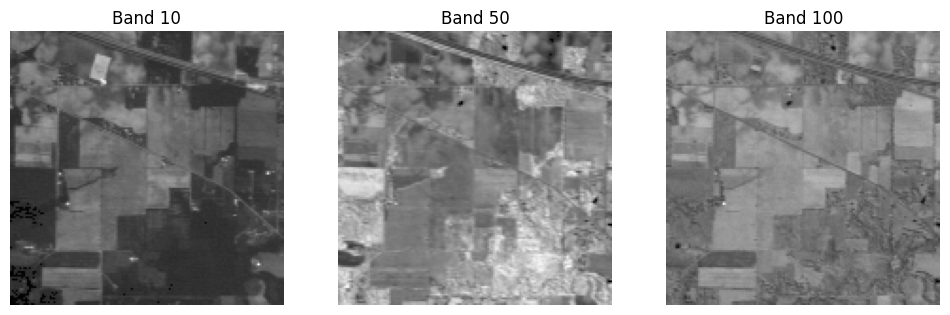

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
bands = [10, 50, 100]

for ax, b in zip(axes, bands):
    ax.imshow(X[:, :, b], cmap='gray')
    ax.set_title(f"Band {b}")
    ax.axis("off")

plt.show()

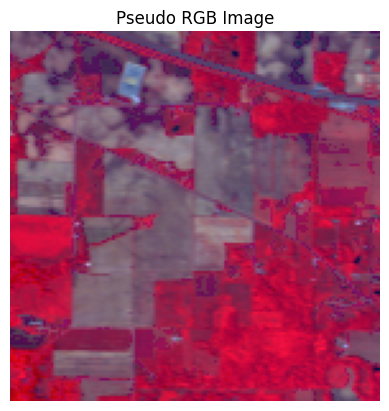

In [18]:
# Choose 3 bands (commonly used combo)
r, g, b = 50, 30, 10

rgb = np.stack([X[:, :, r],
                X[:, :, g],
                X[:, :, b]], axis=2)

# Normalize for display
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

plt.imshow(rgb)
plt.title("Pseudo RGB Image")
plt.axis("off")
plt.show()

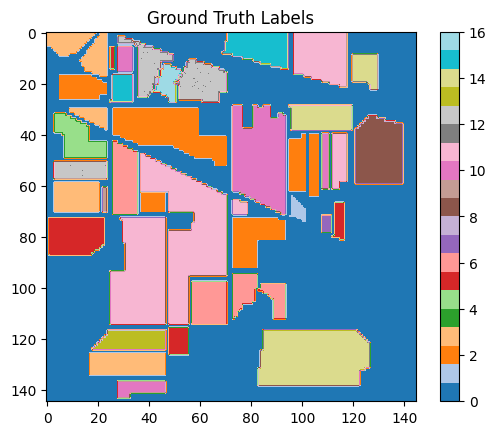

In [19]:
plt.imshow(y, cmap='tab20')
plt.title("Ground Truth Labels")
plt.colorbar()
plt.show()

In [20]:
class_1 = 1
class_2 = 2

coords_1 = np.argwhere(y == class_1)
coords_2 = np.argwhere(y == class_2)

# Pick one pixel from each class
r1, c1 = coords_1[0]
r2, c2 = coords_2[0]

print((r1, c1), (r2, c2))

(np.int64(64), np.int64(96)) (np.int64(17), np.int64(5))


In [21]:
# Extract spectral signatures

spec_1 = X[r1, c1, :]
spec_2 = X[r2, c2, :]

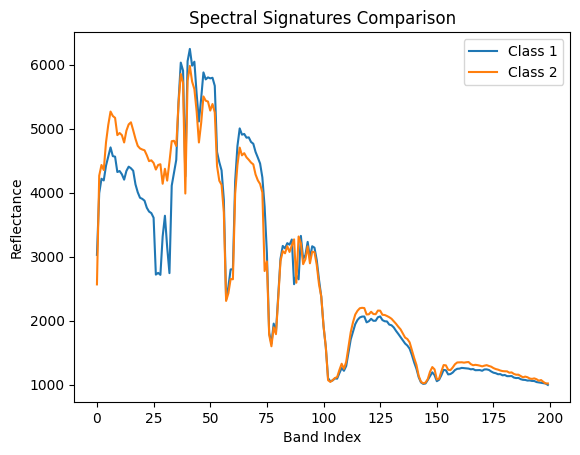

In [22]:
plt.plot(spec_1, label=f"Class {class_1}")
plt.plot(spec_2, label=f"Class {class_2}")
plt.xlabel("Band Index")
plt.ylabel("Reflectance")
plt.title("Spectral Signatures Comparison")
plt.legend()
plt.show()

What you should observe
- Curves have different shapes
- Some bands separate classes better
- Nearby bands are highly correlated

If curves looked identical → classification would be impossible.
___

Next process removes the 0 class from the dataset.
- Label 0 is not a real class
- Background dominates the image
- Models will bias toward predicting 0

In [24]:
# Flattening images
rows, cols, bands = X.shape
X_flat = X.reshape(rows * cols, bands)
y_flat = y.reshape(rows * cols)

# remove noise
mask = y_flat > 0
X_clean = X_flat[mask]
y_clean = y_flat[mask]

print("Original pixels:", rows * cols)
print("After removing background:", X_clean.shape[0])
print("Unique classes:", np.unique(y_clean))


Original pixels: 21025
After removing background: 10249
Unique classes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [27]:
# sanity check. if this runs its good to go
assert 0 not in np.unique(y_clean)

#### NORMALIZATION
Right now, spectral values:
- Have different ranges across bands
- Will confuse distance-based and margin-based models
- Must be scaled before PCA or ML

band-wise normalization is done which is correct in case of HSI


note: only fit training set

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X_clean)

print("Min value:", X_norm.min())
print("Max value:", X_norm.max())

Min value: 0.0
Max value: 1.0000000000000009


#### PCA (DIMENSIONALITY REDUCTION)
Why PCA is mandatory in HSI:
- 200 bands are highly correlated
- Many bands carry redundant information
- PCA reduces noise and computation
- Most HSI papers use PCA before ML

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99, random_state=42)
X_pca = pca.fit_transform(X_norm)

/Users/ameen/MyDrive/Research/Works/Codes/venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/ameen/MyDrive/Research/Works/Codes/venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/ameen/MyDrive/Research/Works/Codes/venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/ameen/MyDrive/Research/Works/Codes/venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ameen/MyDrive/Research/Works/Codes/venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ameen/MyDrive/Research/Works/Codes/venv/lib/python3.9/site-packag

In [32]:
# check shape after PCA
print("Original shape:", X_norm.shape)
print("After PCA:", X_pca.shape)

Original shape: (10249, 200)
After PCA: (10249, 31)


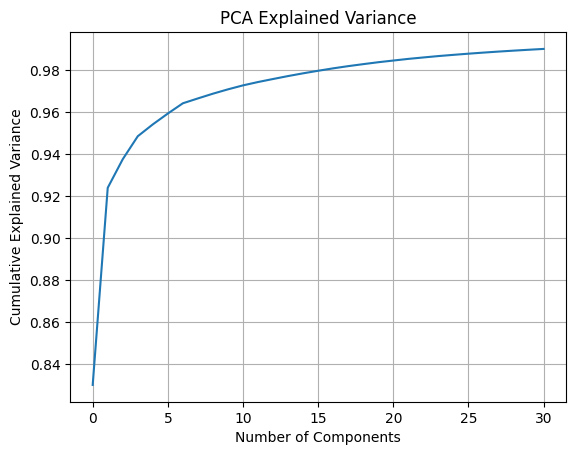

In [33]:
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cum_var)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()
